# Import Dependencies and Data

In [ ]:
!pip install tensorflow matplotlib

In [ ]:
!pip list

In [ ]:
import os
# matplotlib for visualization
from matplotlib import pyplot as plt
import numpy as np
from numpy import random
import matplotlib.image as mpimg
import pandas as pd
import cv2 as cv

# data loader imports
import torch
import torchvision.transforms as transforms
from torchvision import datasets, transforms

In [ ]:
# getting the kaggle dataset
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrinmoyeemishra1","key":"0222ea602d7640f4737ddb5c6895f83b"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets list

ref                                                                   title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                      25KB  2023-04-13 09:55:16          40137       1156  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                            6KB  2023-05-28 18:26:48           6915        178  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                22KB  2023-05-12 13:06:39           8592        180  1.0              
mohithsairamreddy/salary-data                

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

100% 2.28G/2.29G [00:21<00:00, 138MB/s]
100% 2.29G/2.29G [00:21<00:00, 113MB/s]


In [ ]:
!unzip best-artworks-of-all-time.zip

Streaming output truncated to the last 5000 lines.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflat

# Viz Data and Build Datasets

(237, 600, 3)
(32, 32, 3)
(1229, 896, 3)
(32, 32, 3)
(578, 480, 3)
(32, 32, 3)
(381, 600, 3)
(32, 32, 3)
(441, 322, 3)
(32, 32, 3)
(620, 614, 3)
(32, 32, 3)
(299, 614, 3)
(32, 32, 3)
(484, 367, 3)
(32, 32, 3)


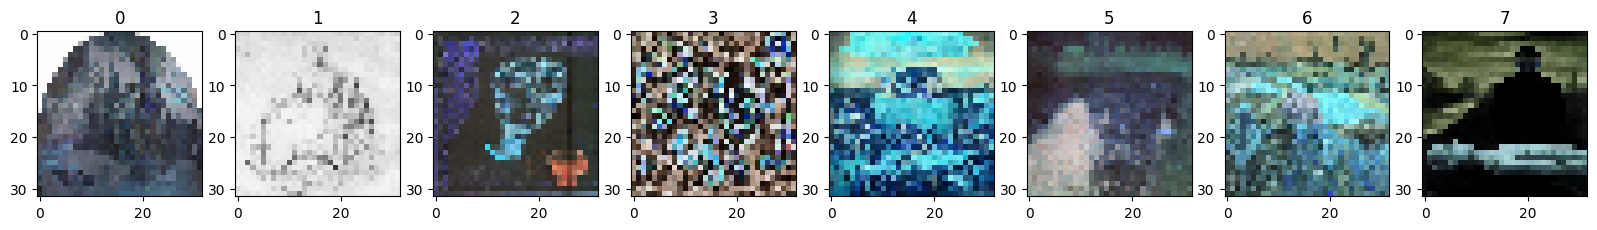

In [ ]:
# Set the directory path where the images are stored
image_dir = '/content/resized/resized'
numOFDisplayImages = 8

# Get the list of image files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

fig, ax = plt.subplots(ncols=numOFDisplayImages, figsize=(20,20))
for idx in range(numOFDisplayImages):
    image = image_files[idx]

    # read the image
    image_path = os.path.join(image_dir, image)
    sample_img = cv.imread(image_path)
    print(sample_img.shape)

    if sample_img is not None:
        # resize the image
        sample_img = cv.resize(sample_img, (32, 32))
        print(sample_img.shape)
        # display the image
        ax[idx].imshow(np.squeeze(sample_img))
        ax[idx].set_title(str(idx))
    else:
        print(f"Failed to read image: {image}")

plt.show()



In [ ]:
# Data Loader

# tensorflow data loading steps
# map, cache, shuffle, batch, prefetch

# sets the number of images that will be processed for each training iteration
batch_size = 32
# sets the size of the input image (64x64)
image_size = 64

# creates a list of random image transformations to be applied during training.
# such as color jittering and random rotation
def get_dataloader(batch_size,image_size,num_workers=3):
    # chains multiple transformations together
    # transformations:
    # -- resizing image to 64x64 pixels
    # -- converting the image to a tensor
    # -- normalizing the pixel values mean=0.5 sd=0.5
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = datasets.ImageFolder('/content/resized/', transform=transform)

    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return data_loader


# Build Neural Network (GAN)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from numpy import expand_dims, zeros, ones, vstack
from numpy.random import randn, randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
import random
from PIL import Image

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 4x4 image with 256 filters
  # 4096 nodes
  n_nodes = 256 * 4 * 4

  # adds a fully connected layer to the model
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model


# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()

  # normal
  # 64 filters, 3x3 convolutional kernel matrix, input shape is 32x32 (original img size)
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model


# # disc
discriminator_model = define_discriminator()
discriminator_model.summary()
# plot_model(discriminator_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)


# # gen
generator_model = define_generator(100)
generator_model.summary()
# plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
# load and prepare cifar10 training images
def load_imgs():
  # load dataset
  numImages = len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))])

  X = np.zeros((numImages, 32, 32, 3), dtype=np.float32) # change as per image size
  all_img_files = os.listdir(image_dir)

  i = 0
  for file in all_img_files:
    filename = os.fsdecode(file)
    toLoad = os.path.join(image_dir, filename)
    image = Image.open(toLoad).convert("RGB").resize((32, 32))
    X[i] = np.array(image, dtype=np.float32)
    i+=1

  # all_img_files = os.listdir(image_dir)

  # images = []
  # for file in all_img_files:
  #   image_path = os.path.join(image_dir, file)
  #   image = cv.imread(image_path)
  #   image = cv.resize(image, (32,32))
  #   images.append(image)

  # x = np.zeros((len(images), 32, 32, 3))

  #  convert from unsigned ints to floats
  # x = x.astype('float32')

  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5

  return X



def generate_real_imgs(dataset, n):
  # choose random instances

  ix = randint(0, dataset.shape[0], n)

  X = dataset[ix]

  # ix = random.choices(dataset, k=n)
  # X = ix.tolist()

  # # real class label: 1
  y = ones((n, 1))
  return X, y
  # y = [[1]] * n
  # return ix, y



# use the generator to generate n fake examples, with class labels
def generate_fake_imgs(g_model, latent_dim, n):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n)
  # predict outputs
  X = g_model.predict(x_input)
  # create fake class label: 0
  y = zeros((n, 1))
  return X, y


# input for the generator: generate points in latent space
def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  x_input = randn(latent_dim * n)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latent_dim)
  return x_input


def save(fake_imgs, epoch, n=7):
  # scale from [-1,1] to [0,1]
  fake_imgs = (fake_imgs + 1) / 2.0
  num_of_display_images = min(n * n, fake_imgs.shape[0])
  fig, ax = pyplot.subplots(ncols=num_of_display_images, figsize=(32, 32))
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(fake_imgs[i])
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

    image = Image.open(filename)
    ax[i].imshow(image)



def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n=150):
  # prepare the real samples
  x_real, y_real = generate_real_imgs(dataset, n)
  # prepare the fake samples
  x_fake, y_fake = generate_fake_imgs(generator, latent_dim, n)

  # evaluating the discriminator with real imgs
  result, accuracy_real = discriminator.evaluate(x_real, y_real, verbose=0)
  # evaluating with fake imgs
  result, accuracy_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)

  print('>Accuracy\n real: %.0f%%, fake: %.0f%%' % (accuracy_real*100, accuracy_fake*100))

  # save plot
  save(x_fake, epoch)

  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  generator.save(filename)




# def train(generator, discriminator, gan, dataset, latent_dim, epochs=20, batch=32):
#   batch_per_epoch = int(dataset.shape[0] / batch)
#   half_batch = int(batch/2)

#   for i in range(epochs):
#     for j in range(batch_per_epoch):
#       x_real, y_real = generate_real_imgs(dataset, half_batch)
#       # x_real = np.array(x_real)  # Convert x_real to a NumPy array
#       # y_real = np.array(y_real)  # Convert y_real to a NumPy array
#       disc_loss1, _ = discriminator.train_on_batch(x_real, y_real)

#       x_fake, y_fake = generate_fake_imgs(generator, latent_dim, half_batch)
#       # x_fake = np.array(x_fake)  # Convert x_fake to a NumPy array
#       # y_fake = np.array(y_fake)  # Convert y_fake to a NumPy array
#       # x_fake = np.reshape(x_fake, (half_batch, 32, 32, 3))
#       disc_loss2, _ = discriminator(x_fake, y_fake)

#       x_gan = generate_latent_points(latent_dim, batch)
#       # x_gan = np.array(x_gan)

#       y_gan = ones((batch, 1))

#       gen_loss = gan.train_on_batch(x_gan, y_gan)
#       # summarize loss on this batch
#       print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, batch_per_epoch, disc_loss1, disc_loss2, gen_loss))

#   # evaluate the model performance, sometimes
#     if (i+1) % 10 == 0:
#       summarize_performance(i, generator, discriminator, dataset, latent_dim)
def train(generator, discriminator, gan, dataset, latent_dim, epochs=30, batch=32):
    batch_per_epoch = dataset.shape[0] // batch
    half_batch = batch // 2

    for i in range(epochs):
        for j in range(batch_per_epoch):
            x_real, y_real = generate_real_imgs(dataset, half_batch)
            disc_loss1, _ = discriminator.train_on_batch(x_real, y_real)

            x_fake, y_fake = generate_fake_imgs(generator, latent_dim, half_batch)
            disc_loss2, _ = discriminator.train_on_batch(x_fake, y_fake)

            x_gan = generate_latent_points(latent_dim, batch)
            y_gan = np.ones((batch, 1))

            gen_loss = gan.train_on_batch(x_gan, y_gan)

            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, batch_per_epoch, disc_loss1, disc_loss2, gen_loss))


        summarize_performance(i, generator, discriminator, dataset, latent_dim)



# size of the latent space (converts pixel values in an image to points and values)
latent_dim = 100

discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

dataset = load_imgs()
train(generator, discriminator, gan_model, dataset, latent_dim)

1/1 [==============================] - 0s 230ms/step
>1, 1/271, d1=0.693, d2=0.695 g=0.692
1/1 [==============================] - 0s 131ms/step
>1, 2/271, d1=0.624, d2=0.697 g=0.690
1/1 [==============================] - 0s 138ms/step
>1, 3/271, d1=0.565, d2=0.702 g=0.685
1/1 [==============================] - 0s 135ms/step
>1, 4/271, d1=0.491, d2=0.714 g=0.672
1/1 [==============================] - 0s 151ms/step
>1, 5/271, d1=0.370, d2=0.748 g=0.643
1/1 [==============================] - 0s 132ms/step
>1, 6/271, d1=0.259, d2=0.824 g=0.592
1/1 [==============================] - 0s 138ms/step
>1, 7/271, d1=0.209, d2=0.940 g=0.541
1/1 [==============================] - 0s 135ms/step
>1, 8/271, d1=0.212, d2=1.046 g=0.533
1/1 [==============================] - 0s 216ms/step
>1, 9/271, d1=0.191, d2=0.972 g=0.578
1/1 [==============================] - 0s 134ms/step
>1, 10/271, d1=0.205, d2=0.861 g=0.692
1/1 [==============================] - 0s 133ms/step
>1, 11/271, d1=0.272, d2=0.691 g=0.8

<ipython-input-13-d9bef0261c59>:83: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(n, n, 1 + i)


1/1 [==============================] - 0s 139ms/step
>2, 1/271, d1=0.019, d2=0.154 g=2.311
1/1 [==============================] - 0s 138ms/step
>2, 2/271, d1=0.037, d2=1.301 g=1.656
1/1 [==============================] - 0s 140ms/step
>2, 3/271, d1=0.319, d2=7.408 g=0.708
1/1 [==============================] - 0s 137ms/step
>2, 4/271, d1=0.194, d2=2.632 g=2.196
1/1 [==============================] - 0s 140ms/step
>2, 5/271, d1=0.308, d2=0.133 g=4.057
1/1 [==============================] - 0s 138ms/step
>2, 6/271, d1=0.474, d2=0.132 g=3.250
1/1 [==============================] - 0s 212ms/step
>2, 7/271, d1=0.397, d2=0.474 g=3.015
1/1 [==============================] - 0s 131ms/step
>2, 8/271, d1=0.207, d2=0.416 g=4.079
1/1 [==============================] - 0s 145ms/step
>2, 9/271, d1=1.815, d2=1.584 g=0.940
1/1 [==============================] - 0s 141ms/step
>2, 10/271, d1=0.230, d2=1.002 g=2.472
1/1 [==============================] - 0s 140ms/step
>2, 11/271, d1=1.388, d2=0.289 g=1.7

1/1 [==============================] - 0s 142ms/step
>3, 1/271, d1=0.348, d2=0.285 g=2.067
1/1 [==============================] - 0s 135ms/step
>3, 2/271, d1=0.473, d2=0.399 g=2.601
1/1 [==============================] - 0s 233ms/step
>3, 3/271, d1=0.723, d2=0.228 g=2.251
1/1 [==============================] - 0s 142ms/step
>3, 4/271, d1=0.557, d2=0.620 g=1.528
1/1 [==============================] - 0s 140ms/step
>3, 5/271, d1=0.737, d2=0.619 g=1.588
1/1 [==============================] - 0s 134ms/step
>3, 6/271, d1=0.636, d2=0.274 g=1.870
1/1 [==============================] - 0s 143ms/step
>3, 7/271, d1=0.641, d2=0.366 g=1.795
1/1 [==============================] - 0s 138ms/step
>3, 8/271, d1=0.468, d2=0.233 g=1.651
1/1 [==============================] - 0s 140ms/step
>3, 9/271, d1=0.481, d2=0.375 g=2.323
1/1 [==============================] - 0s 144ms/step
>3, 10/271, d1=0.512, d2=0.232 g=2.121
1/1 [==============================] - 0s 136ms/step
>3, 11/271, d1=0.800, d2=0.797 g=1.3

1/1 [==============================] - 0s 179ms/step
>4, 1/271, d1=0.508, d2=0.611 g=1.256
1/1 [==============================] - 0s 136ms/step
>4, 2/271, d1=0.678, d2=0.476 g=1.413
1/1 [==============================] - 0s 216ms/step
>4, 3/271, d1=0.660, d2=0.463 g=1.564
1/1 [==============================] - 0s 200ms/step
>4, 4/271, d1=0.686, d2=0.411 g=1.411
1/1 [==============================] - 0s 137ms/step
>4, 5/271, d1=0.570, d2=0.283 g=1.354
1/1 [==============================] - 0s 135ms/step
>4, 6/271, d1=0.659, d2=0.424 g=1.401
1/1 [==============================] - 0s 136ms/step
>4, 7/271, d1=0.589, d2=0.466 g=1.222
1/1 [==============================] - 0s 135ms/step
>4, 8/271, d1=0.416, d2=0.593 g=1.279
1/1 [==============================] - 0s 133ms/step
>4, 9/271, d1=0.558, d2=0.405 g=1.245
1/1 [==============================] - 0s 134ms/step
>4, 10/271, d1=0.480, d2=0.414 g=1.405
1/1 [==============================] - 0s 132ms/step
>4, 11/271, d1=0.892, d2=0.618 g=1.0

1/1 [==============================] - 0s 170ms/step
>5, 1/271, d1=0.937, d2=0.518 g=1.103
1/1 [==============================] - 0s 213ms/step
>5, 2/271, d1=0.875, d2=0.911 g=1.203
1/1 [==============================] - 0s 150ms/step
>5, 3/271, d1=0.941, d2=0.520 g=1.189
1/1 [==============================] - 0s 133ms/step
>5, 4/271, d1=0.658, d2=0.666 g=1.320
1/1 [==============================] - 0s 134ms/step
>5, 5/271, d1=1.037, d2=0.370 g=1.428
1/1 [==============================] - 0s 135ms/step
>5, 6/271, d1=0.971, d2=0.386 g=1.324
1/1 [==============================] - 0s 137ms/step
>5, 7/271, d1=0.781, d2=0.431 g=1.435
1/1 [==============================] - 0s 135ms/step
>5, 8/271, d1=0.747, d2=0.382 g=1.324
1/1 [==============================] - 0s 140ms/step
>5, 9/271, d1=0.677, d2=0.455 g=1.411
1/1 [==============================] - 0s 144ms/step
>5, 10/271, d1=0.848, d2=0.343 g=1.368
1/1 [==============================] - 0s 214ms/step
>5, 11/271, d1=0.740, d2=0.430 g=1.3

1/1 [==============================] - 0s 142ms/step
>6, 1/271, d1=0.614, d2=0.785 g=0.833
1/1 [==============================] - 0s 169ms/step
>6, 2/271, d1=0.781, d2=0.966 g=0.934
1/1 [==============================] - 0s 239ms/step
>6, 3/271, d1=0.899, d2=0.658 g=1.128
1/1 [==============================] - 0s 148ms/step
>6, 4/271, d1=0.779, d2=0.691 g=1.131
1/1 [==============================] - 0s 140ms/step
>6, 5/271, d1=0.761, d2=0.748 g=1.205
1/1 [==============================] - 0s 142ms/step
>6, 6/271, d1=0.613, d2=0.484 g=1.307
1/1 [==============================] - 0s 148ms/step
>6, 7/271, d1=0.835, d2=0.513 g=1.228
1/1 [==============================] - 0s 144ms/step
>6, 8/271, d1=0.585, d2=0.539 g=1.278
1/1 [==============================] - 0s 146ms/step
>6, 9/271, d1=0.535, d2=0.633 g=1.256
1/1 [==============================] - 0s 142ms/step
>6, 10/271, d1=0.712, d2=0.512 g=1.376
1/1 [==============================] - 0s 139ms/step
>6, 11/271, d1=0.926, d2=0.754 g=1.1

1/1 [==============================] - 0s 229ms/step
>7, 1/271, d1=0.585, d2=0.639 g=0.971
1/1 [==============================] - 0s 215ms/step
>7, 2/271, d1=0.597, d2=0.546 g=0.902
1/1 [==============================] - 0s 138ms/step
>7, 3/271, d1=0.462, d2=0.518 g=0.914
1/1 [==============================] - 0s 143ms/step
>7, 4/271, d1=0.736, d2=0.614 g=1.068
1/1 [==============================] - 0s 150ms/step
>7, 5/271, d1=0.602, d2=0.577 g=0.991
1/1 [==============================] - 0s 147ms/step
>7, 6/271, d1=0.607, d2=0.583 g=1.069
1/1 [==============================] - 0s 136ms/step
>7, 7/271, d1=0.462, d2=0.488 g=1.111
1/1 [==============================] - 0s 147ms/step
>7, 8/271, d1=0.504, d2=0.437 g=1.053
1/1 [==============================] - 0s 140ms/step
>7, 9/271, d1=0.518, d2=0.537 g=1.207
1/1 [==============================] - 0s 136ms/step
>7, 10/271, d1=0.547, d2=0.475 g=1.308
1/1 [==============================] - 0s 217ms/step
>7, 11/271, d1=0.568, d2=0.495 g=1.3

1/1 [==============================] - 0s 225ms/step
>8, 1/271, d1=0.718, d2=0.703 g=1.085
1/1 [==============================] - 0s 136ms/step
>8, 2/271, d1=0.651, d2=0.693 g=1.222
1/1 [==============================] - 0s 137ms/step
>8, 3/271, d1=0.518, d2=0.533 g=1.158
1/1 [==============================] - 0s 147ms/step
>8, 4/271, d1=0.710, d2=0.527 g=1.174
1/1 [==============================] - 0s 139ms/step
>8, 5/271, d1=0.663, d2=0.525 g=1.314
1/1 [==============================] - 0s 140ms/step
>8, 6/271, d1=0.673, d2=0.484 g=1.075
1/1 [==============================] - 0s 137ms/step
>8, 7/271, d1=0.567, d2=0.486 g=1.196
1/1 [==============================] - 0s 143ms/step
>8, 8/271, d1=0.462, d2=0.552 g=1.201
1/1 [==============================] - 0s 141ms/step
>8, 9/271, d1=0.550, d2=0.547 g=1.241
1/1 [==============================] - 0s 136ms/step
>8, 10/271, d1=0.545, d2=0.446 g=1.286
1/1 [==============================] - 0s 219ms/step
>8, 11/271, d1=0.443, d2=0.572 g=1.2

1/1 [==============================] - 0s 138ms/step
>9, 1/271, d1=0.619, d2=0.475 g=1.127
1/1 [==============================] - 0s 154ms/step
>9, 2/271, d1=0.592, d2=0.568 g=1.086
1/1 [==============================] - 0s 152ms/step
>9, 3/271, d1=0.609, d2=0.543 g=1.138
1/1 [==============================] - 0s 147ms/step
>9, 4/271, d1=0.642, d2=0.578 g=1.195
1/1 [==============================] - 0s 148ms/step
>9, 5/271, d1=0.593, d2=0.515 g=1.101
1/1 [==============================] - 0s 161ms/step
>9, 6/271, d1=0.606, d2=0.462 g=1.025
1/1 [==============================] - 0s 157ms/step
>9, 7/271, d1=0.588, d2=0.753 g=1.057
1/1 [==============================] - 0s 142ms/step
>9, 8/271, d1=0.649, d2=0.668 g=1.029
1/1 [==============================] - 0s 143ms/step
>9, 9/271, d1=0.733, d2=0.520 g=1.022
1/1 [==============================] - 0s 225ms/step
>9, 10/271, d1=0.537, d2=0.554 g=1.056
1/1 [==============================] - 0s 136ms/step
>9, 11/271, d1=0.762, d2=0.518 g=0.9

1/1 [==============================] - 0s 215ms/step
>10, 1/271, d1=0.585, d2=0.579 g=1.009
1/1 [==============================] - 0s 133ms/step
>10, 2/271, d1=0.715, d2=0.692 g=1.032
1/1 [==============================] - 0s 147ms/step
>10, 3/271, d1=0.666, d2=0.635 g=1.074
1/1 [==============================] - 0s 135ms/step
>10, 4/271, d1=0.717, d2=0.523 g=1.203
1/1 [==============================] - 0s 136ms/step
>10, 5/271, d1=0.658, d2=0.546 g=1.250
1/1 [==============================] - 0s 138ms/step
>10, 6/271, d1=0.661, d2=0.710 g=1.192
1/1 [==============================] - 0s 138ms/step
>10, 7/271, d1=0.719, d2=0.493 g=1.050
1/1 [==============================] - 0s 138ms/step
>10, 8/271, d1=0.592, d2=0.505 g=1.044
1/1 [==============================] - 0s 136ms/step
>10, 9/271, d1=0.584, d2=0.772 g=1.049
1/1 [==============================] - 0s 140ms/step
>10, 10/271, d1=0.558, d2=0.593 g=0.972
1/1 [==============================] - 0s 224ms/step
>10, 11/271, d1=0.703, d2=

1/1 [==============================] - 0s 140ms/step
>11, 1/271, d1=0.857, d2=0.603 g=1.448
1/1 [==============================] - 0s 140ms/step
>11, 2/271, d1=0.547, d2=0.348 g=1.422
1/1 [==============================] - 0s 149ms/step
>11, 3/271, d1=0.665, d2=0.542 g=1.481
1/1 [==============================] - 0s 146ms/step
>11, 4/271, d1=0.540, d2=0.280 g=1.583
1/1 [==============================] - 0s 146ms/step
>11, 5/271, d1=0.759, d2=0.456 g=1.650
1/1 [==============================] - 0s 145ms/step
>11, 6/271, d1=0.513, d2=0.552 g=1.541
1/1 [==============================] - 0s 145ms/step
>11, 7/271, d1=0.387, d2=0.284 g=1.539
1/1 [==============================] - 0s 146ms/step
>11, 8/271, d1=0.757, d2=0.431 g=1.452
1/1 [==============================] - 0s 233ms/step
>11, 9/271, d1=0.592, d2=0.380 g=1.362
1/1 [==============================] - 0s 214ms/step
>11, 10/271, d1=0.566, d2=0.489 g=1.218
1/1 [==============================] - 0s 145ms/step
>11, 11/271, d1=0.583, d2=

1/1 [==============================] - 0s 146ms/step
>12, 1/271, d1=0.624, d2=0.583 g=1.053
1/1 [==============================] - 0s 133ms/step
>12, 2/271, d1=0.463, d2=0.603 g=1.065
1/1 [==============================] - 0s 141ms/step
>12, 3/271, d1=0.455, d2=0.711 g=1.152
1/1 [==============================] - 0s 170ms/step
>12, 4/271, d1=0.630, d2=0.469 g=1.072
1/1 [==============================] - 0s 138ms/step
>12, 5/271, d1=0.690, d2=0.516 g=1.147
1/1 [==============================] - 0s 142ms/step
>12, 6/271, d1=0.626, d2=0.592 g=1.147
1/1 [==============================] - 0s 140ms/step
>12, 7/271, d1=0.659, d2=0.552 g=1.085
1/1 [==============================] - 0s 145ms/step
>12, 8/271, d1=0.549, d2=0.671 g=1.372
1/1 [==============================] - 0s 234ms/step
>12, 9/271, d1=0.923, d2=0.447 g=1.346
1/1 [==============================] - 0s 146ms/step
>12, 10/271, d1=0.742, d2=0.425 g=1.139
1/1 [==============================] - 0s 142ms/step
>12, 11/271, d1=0.549, d2=

1/1 [==============================] - 0s 219ms/step
>13, 1/271, d1=0.659, d2=0.730 g=1.199
1/1 [==============================] - 0s 214ms/step
>13, 2/271, d1=0.638, d2=0.633 g=1.137
1/1 [==============================] - 0s 142ms/step
>13, 3/271, d1=0.956, d2=0.690 g=1.044
1/1 [==============================] - 0s 144ms/step
>13, 4/271, d1=0.679, d2=0.845 g=0.889
1/1 [==============================] - 0s 140ms/step
>13, 5/271, d1=0.642, d2=0.774 g=1.008
1/1 [==============================] - 0s 137ms/step
>13, 6/271, d1=0.804, d2=0.697 g=1.012
1/1 [==============================] - 0s 146ms/step
>13, 7/271, d1=0.711, d2=0.574 g=1.028
1/1 [==============================] - 0s 141ms/step
>13, 8/271, d1=0.676, d2=0.614 g=0.987
1/1 [==============================] - 0s 135ms/step
>13, 9/271, d1=0.734, d2=0.645 g=0.927
1/1 [==============================] - 0s 149ms/step
>13, 10/271, d1=0.709, d2=0.613 g=0.918
1/1 [==============================] - 0s 214ms/step
>13, 11/271, d1=0.676, d2=

1/1 [==============================] - 0s 148ms/step
>14, 1/271, d1=0.440, d2=0.559 g=1.035
1/1 [==============================] - 0s 143ms/step
>14, 2/271, d1=0.534, d2=0.617 g=1.125
1/1 [==============================] - 0s 144ms/step
>14, 3/271, d1=0.526, d2=0.588 g=1.134
1/1 [==============================] - 0s 144ms/step
>14, 4/271, d1=0.320, d2=0.533 g=1.063
1/1 [==============================] - 0s 143ms/step
>14, 5/271, d1=0.443, d2=0.627 g=1.166
1/1 [==============================] - 0s 220ms/step
>14, 6/271, d1=0.567, d2=0.480 g=1.146
1/1 [==============================] - 0s 219ms/step
>14, 7/271, d1=0.544, d2=0.681 g=1.218
1/1 [==============================] - 0s 138ms/step
>14, 8/271, d1=0.460, d2=0.505 g=1.168
1/1 [==============================] - 0s 139ms/step
>14, 9/271, d1=0.559, d2=0.561 g=1.131
1/1 [==============================] - 0s 139ms/step
>14, 10/271, d1=0.618, d2=0.674 g=1.235
1/1 [==============================] - 0s 137ms/step
>14, 11/271, d1=0.379, d2=

1/1 [==============================] - 0s 136ms/step
>15, 1/271, d1=0.544, d2=0.548 g=1.308
1/1 [==============================] - 0s 135ms/step
>15, 2/271, d1=0.665, d2=0.557 g=1.256
1/1 [==============================] - 0s 145ms/step
>15, 3/271, d1=0.366, d2=0.631 g=1.262
1/1 [==============================] - 0s 146ms/step
>15, 4/271, d1=0.563, d2=0.662 g=1.173
1/1 [==============================] - 0s 222ms/step
>15, 5/271, d1=0.730, d2=0.496 g=1.159
1/1 [==============================] - 0s 209ms/step
>15, 6/271, d1=0.668, d2=0.621 g=1.110
1/1 [==============================] - 0s 139ms/step
>15, 7/271, d1=0.787, d2=0.479 g=1.082
1/1 [==============================] - 0s 142ms/step
>15, 8/271, d1=0.613, d2=0.512 g=1.099
1/1 [==============================] - 0s 134ms/step
>15, 9/271, d1=0.593, d2=0.555 g=1.087
1/1 [==============================] - 0s 164ms/step
>15, 10/271, d1=0.748, d2=0.657 g=1.022
1/1 [==============================] - 0s 147ms/step
>15, 11/271, d1=0.586, d2=

1/1 [==============================] - 0s 139ms/step
>16, 1/271, d1=1.019, d2=0.518 g=1.322
1/1 [==============================] - 0s 140ms/step
>16, 2/271, d1=0.834, d2=0.720 g=1.160
1/1 [==============================] - 0s 142ms/step
>16, 3/271, d1=0.703, d2=0.896 g=1.004
1/1 [==============================] - 0s 218ms/step
>16, 4/271, d1=0.742, d2=1.018 g=1.048
1/1 [==============================] - 0s 145ms/step
>16, 5/271, d1=0.656, d2=0.551 g=1.154
1/1 [==============================] - 0s 145ms/step
>16, 6/271, d1=0.776, d2=0.498 g=1.106
1/1 [==============================] - 0s 137ms/step
>16, 7/271, d1=0.794, d2=0.672 g=1.325
1/1 [==============================] - 0s 139ms/step
>16, 8/271, d1=1.095, d2=0.334 g=1.295
1/1 [==============================] - 0s 135ms/step
>16, 9/271, d1=0.961, d2=0.654 g=1.060
1/1 [==============================] - 0s 135ms/step
>16, 10/271, d1=0.872, d2=0.889 g=1.082
1/1 [==============================] - 0s 149ms/step
>16, 11/271, d1=0.820, d2=

1/1 [==============================] - 0s 218ms/step
>17, 1/271, d1=0.627, d2=0.412 g=1.328
1/1 [==============================] - 0s 149ms/step
>17, 2/271, d1=0.855, d2=0.499 g=1.462
1/1 [==============================] - 0s 145ms/step
>17, 3/271, d1=0.709, d2=0.435 g=1.297
1/1 [==============================] - 0s 153ms/step
>17, 4/271, d1=0.667, d2=0.548 g=1.400
1/1 [==============================] - 0s 141ms/step
>17, 5/271, d1=0.709, d2=0.429 g=1.353
1/1 [==============================] - 0s 138ms/step
>17, 6/271, d1=0.741, d2=0.569 g=1.160
1/1 [==============================] - 0s 132ms/step
>17, 7/271, d1=0.696, d2=0.623 g=1.067
1/1 [==============================] - 0s 148ms/step
>17, 8/271, d1=0.570, d2=0.598 g=1.005
1/1 [==============================] - 0s 133ms/step
>17, 9/271, d1=0.639, d2=0.685 g=1.057
1/1 [==============================] - 0s 252ms/step
>17, 10/271, d1=0.622, d2=0.579 g=1.027
1/1 [==============================] - 0s 230ms/step
>17, 11/271, d1=0.548, d2=

1/1 [==============================] - 0s 130ms/step
>18, 1/271, d1=0.753, d2=0.493 g=1.069
1/1 [==============================] - 0s 134ms/step
>18, 2/271, d1=0.659, d2=0.561 g=0.859
1/1 [==============================] - 0s 133ms/step
>18, 3/271, d1=0.815, d2=0.674 g=0.983
1/1 [==============================] - 0s 146ms/step
>18, 4/271, d1=0.502, d2=0.747 g=0.933
1/1 [==============================] - 0s 138ms/step
>18, 5/271, d1=0.805, d2=0.722 g=0.990
1/1 [==============================] - 0s 142ms/step
>18, 6/271, d1=0.634, d2=0.668 g=1.020
1/1 [==============================] - 0s 140ms/step
>18, 7/271, d1=0.727, d2=0.601 g=1.045
1/1 [==============================] - 0s 137ms/step
>18, 8/271, d1=0.757, d2=0.724 g=1.003
1/1 [==============================] - 0s 142ms/step
>18, 9/271, d1=0.722, d2=0.634 g=1.176
1/1 [==============================] - 0s 216ms/step
>18, 10/271, d1=0.726, d2=0.635 g=1.333
1/1 [==============================] - 0s 142ms/step
>18, 11/271, d1=0.786, d2=

1/1 [==============================] - 0s 135ms/step
>19, 1/271, d1=0.851, d2=0.690 g=1.058
1/1 [==============================] - 0s 150ms/step
>19, 2/271, d1=0.659, d2=0.613 g=1.077
1/1 [==============================] - 0s 151ms/step
>19, 3/271, d1=0.630, d2=0.652 g=1.069
1/1 [==============================] - 0s 135ms/step
>19, 4/271, d1=0.829, d2=0.733 g=0.942
1/1 [==============================] - 0s 140ms/step
>19, 5/271, d1=0.506, d2=0.939 g=1.211
1/1 [==============================] - 0s 143ms/step
>19, 6/271, d1=0.715, d2=0.539 g=1.255
1/1 [==============================] - 0s 140ms/step
>19, 7/271, d1=0.927, d2=0.596 g=1.274
1/1 [==============================] - 0s 215ms/step
>19, 8/271, d1=0.782, d2=0.537 g=1.098
1/1 [==============================] - 0s 136ms/step
>19, 9/271, d1=0.760, d2=0.658 g=1.001
1/1 [==============================] - 0s 138ms/step
>19, 10/271, d1=0.816, d2=0.999 g=1.192
1/1 [==============================] - 0s 148ms/step
>19, 11/271, d1=0.930, d2=

1/1 [==============================] - 0s 150ms/step
>20, 1/271, d1=0.706, d2=0.704 g=1.082
1/1 [==============================] - 0s 149ms/step
>20, 2/271, d1=0.707, d2=0.700 g=1.097
1/1 [==============================] - 0s 143ms/step
>20, 3/271, d1=0.587, d2=0.663 g=1.119
1/1 [==============================] - 0s 225ms/step
>20, 4/271, d1=0.623, d2=0.617 g=1.087
1/1 [==============================] - 0s 150ms/step
>20, 5/271, d1=0.600, d2=0.583 g=1.030
1/1 [==============================] - 0s 141ms/step
>20, 6/271, d1=0.513, d2=0.617 g=1.214
1/1 [==============================] - 0s 151ms/step
>20, 7/271, d1=0.603, d2=0.505 g=1.128
1/1 [==============================] - 0s 145ms/step
>20, 8/271, d1=0.673, d2=0.616 g=0.999
1/1 [==============================] - 0s 143ms/step
>20, 9/271, d1=0.458, d2=0.594 g=1.136
1/1 [==============================] - 0s 147ms/step
>20, 10/271, d1=0.693, d2=0.561 g=0.964
1/1 [==============================] - 0s 141ms/step
>20, 11/271, d1=0.489, d2=

1/1 [==============================] - 0s 230ms/step
>21, 1/271, d1=0.709, d2=0.596 g=1.279
1/1 [==============================] - 0s 203ms/step
>21, 2/271, d1=1.062, d2=0.374 g=1.168
1/1 [==============================] - 0s 149ms/step
>21, 3/271, d1=0.564, d2=0.686 g=1.035
1/1 [==============================] - 0s 140ms/step
>21, 4/271, d1=0.441, d2=0.606 g=1.328
1/1 [==============================] - 0s 141ms/step
>21, 5/271, d1=0.648, d2=0.613 g=1.305
1/1 [==============================] - 0s 144ms/step
>21, 6/271, d1=0.805, d2=0.480 g=1.135
1/1 [==============================] - 0s 143ms/step
>21, 7/271, d1=0.703, d2=0.495 g=1.071
1/1 [==============================] - 0s 138ms/step
>21, 8/271, d1=0.686, d2=0.763 g=0.880
1/1 [==============================] - 0s 139ms/step
>21, 9/271, d1=0.703, d2=0.732 g=1.163
1/1 [==============================] - 0s 149ms/step
>21, 10/271, d1=0.845, d2=0.647 g=1.108
1/1 [==============================] - 0s 219ms/step
>21, 11/271, d1=0.653, d2=

1/1 [==============================] - 0s 139ms/step
>22, 1/271, d1=0.566, d2=0.347 g=1.714
1/1 [==============================] - 0s 139ms/step
>22, 2/271, d1=0.481, d2=0.497 g=1.695
1/1 [==============================] - 0s 147ms/step
>22, 3/271, d1=0.440, d2=0.657 g=1.576
1/1 [==============================] - 0s 152ms/step
>22, 4/271, d1=0.476, d2=0.443 g=1.406
1/1 [==============================] - 0s 134ms/step
>22, 5/271, d1=0.309, d2=0.317 g=1.262
1/1 [==============================] - 0s 142ms/step
>22, 6/271, d1=0.496, d2=0.834 g=1.257
1/1 [==============================] - 0s 138ms/step
>22, 7/271, d1=0.571, d2=0.441 g=1.514
1/1 [==============================] - 0s 168ms/step
>22, 8/271, d1=0.614, d2=0.478 g=1.016
1/1 [==============================] - 0s 222ms/step
>22, 9/271, d1=0.703, d2=0.906 g=1.257
1/1 [==============================] - 0s 147ms/step
>22, 10/271, d1=0.854, d2=0.691 g=1.211
1/1 [==============================] - 0s 141ms/step
>22, 11/271, d1=0.535, d2=

1/1 [==============================] - 0s 212ms/step
>23, 1/271, d1=0.522, d2=0.630 g=1.119
1/1 [==============================] - 0s 142ms/step
>23, 2/271, d1=0.762, d2=0.641 g=1.024
1/1 [==============================] - 0s 140ms/step
>23, 3/271, d1=0.518, d2=0.516 g=0.999
1/1 [==============================] - 0s 139ms/step
>23, 4/271, d1=0.431, d2=0.586 g=1.203
1/1 [==============================] - 0s 149ms/step
>23, 5/271, d1=0.537, d2=0.562 g=1.127
1/1 [==============================] - 0s 147ms/step
>23, 6/271, d1=0.427, d2=0.456 g=1.156
1/1 [==============================] - 0s 141ms/step
>23, 7/271, d1=0.371, d2=0.518 g=1.073
1/1 [==============================] - 0s 143ms/step
>23, 8/271, d1=0.325, d2=0.624 g=1.408
1/1 [==============================] - 0s 149ms/step
>23, 9/271, d1=0.441, d2=0.491 g=1.329
1/1 [==============================] - 0s 215ms/step
>23, 10/271, d1=0.514, d2=0.489 g=1.140
1/1 [==============================] - 0s 198ms/step
>23, 11/271, d1=0.693, d2=

1/1 [==============================] - 0s 147ms/step
>24, 1/271, d1=0.576, d2=0.442 g=1.266
1/1 [==============================] - 0s 149ms/step
>24, 2/271, d1=0.764, d2=0.597 g=1.177
1/1 [==============================] - 0s 138ms/step
>24, 3/271, d1=0.384, d2=0.501 g=1.369
1/1 [==============================] - 0s 138ms/step
>24, 4/271, d1=0.530, d2=0.508 g=1.509
1/1 [==============================] - 0s 141ms/step
>24, 5/271, d1=0.444, d2=0.440 g=1.118
1/1 [==============================] - 0s 158ms/step
>24, 6/271, d1=0.519, d2=0.495 g=1.327
1/1 [==============================] - 0s 142ms/step
>24, 7/271, d1=0.391, d2=0.500 g=1.259
1/1 [==============================] - 0s 231ms/step
>24, 8/271, d1=0.183, d2=0.559 g=1.350
1/1 [==============================] - 0s 145ms/step
>24, 9/271, d1=0.509, d2=0.481 g=1.294
1/1 [==============================] - 0s 138ms/step
>24, 10/271, d1=0.453, d2=0.451 g=1.285
1/1 [==============================] - 0s 144ms/step
>24, 11/271, d1=0.498, d2=

1/1 [==============================] - 0s 208ms/step
>25, 1/271, d1=0.566, d2=0.492 g=1.193
1/1 [==============================] - 0s 213ms/step
>25, 2/271, d1=0.494, d2=0.540 g=1.106
1/1 [==============================] - 0s 137ms/step
>25, 3/271, d1=0.662, d2=0.673 g=1.201
1/1 [==============================] - 0s 139ms/step
>25, 4/271, d1=0.479, d2=0.444 g=1.141
1/1 [==============================] - 0s 140ms/step
>25, 5/271, d1=0.816, d2=0.604 g=1.147
1/1 [==============================] - 0s 139ms/step
>25, 6/271, d1=0.462, d2=0.677 g=1.114
1/1 [==============================] - 0s 142ms/step
>25, 7/271, d1=0.560, d2=0.630 g=1.046
1/1 [==============================] - 0s 146ms/step
>25, 8/271, d1=0.555, d2=0.615 g=1.146
1/1 [==============================] - 0s 139ms/step
>25, 9/271, d1=0.753, d2=0.721 g=1.110
1/1 [==============================] - 0s 144ms/step
>25, 10/271, d1=0.692, d2=0.600 g=1.040
1/1 [==============================] - 0s 216ms/step
>25, 11/271, d1=0.691, d2=

1/1 [==============================] - 0s 139ms/step
>26, 1/271, d1=0.610, d2=0.514 g=1.129
1/1 [==============================] - 0s 147ms/step
>26, 2/271, d1=0.578, d2=0.621 g=1.006
1/1 [==============================] - 0s 139ms/step
>26, 3/271, d1=0.513, d2=0.491 g=0.970
1/1 [==============================] - 0s 139ms/step
>26, 4/271, d1=0.715, d2=0.597 g=1.103
1/1 [==============================] - 0s 139ms/step
>26, 5/271, d1=0.775, d2=0.542 g=1.049
1/1 [==============================] - 0s 150ms/step
>26, 6/271, d1=0.489, d2=0.626 g=0.939
1/1 [==============================] - 0s 142ms/step
>26, 7/271, d1=0.615, d2=0.691 g=0.949
1/1 [==============================] - 0s 144ms/step
>26, 8/271, d1=0.508, d2=0.713 g=0.940
1/1 [==============================] - 0s 148ms/step
>26, 9/271, d1=0.714, d2=0.510 g=0.954
1/1 [==============================] - 0s 230ms/step
>26, 10/271, d1=0.436, d2=0.688 g=0.909
1/1 [==============================] - 0s 139ms/step
>26, 11/271, d1=0.479, d2=

1/1 [==============================] - 0s 138ms/step
>27, 1/271, d1=0.610, d2=0.430 g=1.333
1/1 [==============================] - 0s 148ms/step
>27, 2/271, d1=0.740, d2=0.387 g=1.478
1/1 [==============================] - 0s 151ms/step
>27, 3/271, d1=0.683, d2=0.353 g=1.328
1/1 [==============================] - 0s 139ms/step
>27, 4/271, d1=0.790, d2=0.514 g=1.531
1/1 [==============================] - 0s 148ms/step
>27, 5/271, d1=0.587, d2=0.455 g=1.422
1/1 [==============================] - 0s 137ms/step
>27, 6/271, d1=0.548, d2=0.569 g=1.590
1/1 [==============================] - 0s 222ms/step
>27, 7/271, d1=0.772, d2=0.405 g=1.514
1/1 [==============================] - 0s 232ms/step
>27, 8/271, d1=0.750, d2=0.445 g=1.435
1/1 [==============================] - 0s 141ms/step
>27, 9/271, d1=0.719, d2=0.547 g=1.415
1/1 [==============================] - 0s 137ms/step
>27, 10/271, d1=0.559, d2=0.415 g=1.400
1/1 [==============================] - 0s 139ms/step
>27, 11/271, d1=0.569, d2=

1/1 [==============================] - 0s 146ms/step
>28, 1/271, d1=0.444, d2=0.643 g=1.368
1/1 [==============================] - 0s 138ms/step
>28, 2/271, d1=0.549, d2=0.476 g=1.128
1/1 [==============================] - 0s 214ms/step
>28, 3/271, d1=0.689, d2=0.623 g=1.059
1/1 [==============================] - 0s 217ms/step
>28, 4/271, d1=0.610, d2=0.555 g=1.020
1/1 [==============================] - 0s 158ms/step
>28, 5/271, d1=0.571, d2=0.602 g=0.945
1/1 [==============================] - 0s 137ms/step
>28, 6/271, d1=0.739, d2=0.611 g=1.018
1/1 [==============================] - 0s 142ms/step
>28, 7/271, d1=0.789, d2=0.608 g=0.940
1/1 [==============================] - 0s 141ms/step
>28, 8/271, d1=0.572, d2=0.667 g=0.917
1/1 [==============================] - 0s 146ms/step
>28, 9/271, d1=0.632, d2=0.609 g=0.949
1/1 [==============================] - 0s 146ms/step
>28, 10/271, d1=0.476, d2=0.693 g=1.046
1/1 [==============================] - 0s 149ms/step
>28, 11/271, d1=0.740, d2=

1/1 [==============================] - 0s 217ms/step
>29, 1/271, d1=0.777, d2=0.794 g=0.849
1/1 [==============================] - 0s 155ms/step
>29, 2/271, d1=0.644, d2=0.634 g=0.841
1/1 [==============================] - 0s 140ms/step
>29, 3/271, d1=0.766, d2=0.797 g=0.862
1/1 [==============================] - 0s 137ms/step
>29, 4/271, d1=0.629, d2=0.581 g=0.891
1/1 [==============================] - 0s 141ms/step
>29, 5/271, d1=0.691, d2=0.695 g=1.003
1/1 [==============================] - 0s 139ms/step
>29, 6/271, d1=0.577, d2=0.688 g=0.978
1/1 [==============================] - 0s 135ms/step
>29, 7/271, d1=0.719, d2=0.509 g=1.075
1/1 [==============================] - 0s 147ms/step
>29, 8/271, d1=0.592, d2=0.562 g=1.006
1/1 [==============================] - 0s 151ms/step
>29, 9/271, d1=0.838, d2=0.592 g=1.124
1/1 [==============================] - 0s 170ms/step
>29, 10/271, d1=0.641, d2=0.543 g=1.057
1/1 [==============================] - 0s 216ms/step
>29, 11/271, d1=0.633, d2=

1/1 [==============================] - 0s 138ms/step
>30, 1/271, d1=0.518, d2=0.522 g=0.913
1/1 [==============================] - 0s 155ms/step
>30, 2/271, d1=0.586, d2=0.591 g=0.907
1/1 [==============================] - 0s 147ms/step
>30, 3/271, d1=0.631, d2=0.615 g=0.899
1/1 [==============================] - 0s 155ms/step
>30, 4/271, d1=0.526, d2=0.730 g=0.840
1/1 [==============================] - 0s 151ms/step
>30, 5/271, d1=0.573, d2=0.945 g=0.955
1/1 [==============================] - 0s 223ms/step
>30, 6/271, d1=0.737, d2=0.712 g=0.984
1/1 [==============================] - 0s 212ms/step
>30, 7/271, d1=0.784, d2=0.560 g=0.889
1/1 [==============================] - 0s 150ms/step
>30, 8/271, d1=0.682, d2=0.550 g=0.886
1/1 [==============================] - 0s 146ms/step
>30, 9/271, d1=0.639, d2=0.664 g=0.877
1/1 [==============================] - 0s 157ms/step
>30, 10/271, d1=0.643, d2=0.543 g=0.813
1/1 [==============================] - 0s 152ms/step
>30, 11/271, d1=0.700, d2=

In [ ]:
from google.colab import files
files.download('generated_plot_e030.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4/4 [==============================] - 1s 174ms/step


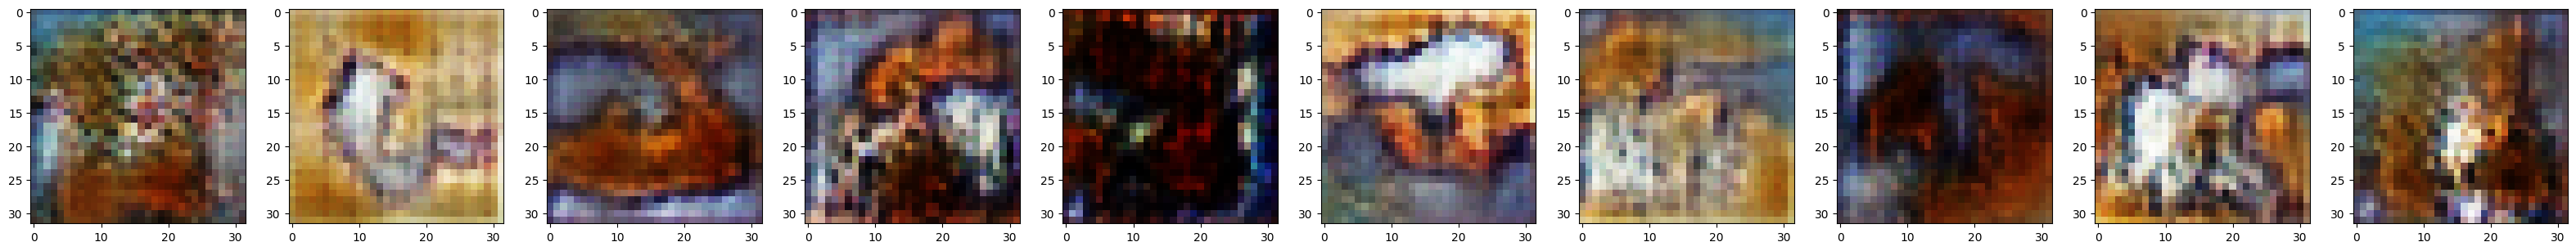

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

def create_plot(examples, n):
    # Create a figure with subplots arranged horizontally
    fig, ax = plt.subplots(1, n, figsize=(n * 4, 4))

    # Plot images
    for i in range(n):

       ax[i].imshow(examples[i])

    plt.show()

# # plot the generated images
# def create_plot(examples, n):
#  # plot images
#  for i in range(n * n):
#   # define subplot
#   pyplot.subplot(n, n, 1 + i)
#   # turn off axis
#   pyplot.axis('off')
#   # plot raw pixel data
#   pyplot.imshow(examples[i, :, :])
#   pyplot.show()

# load model
model = load_model('generator_model_030.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)
